In [1]:
import pandas as pd
import numpy as np
import os
from os import getcwd
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

df = pd.read_csv(getcwd()+"\\Stocks\\a.us.txt", parse_dates=['Date'], date_parser=dateparser)

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-11-18,30.713,33.754,27.002,29.702,66277506,0
1,1999-11-19,28.986,29.027,26.872,27.257,16142920,0
2,1999-11-22,27.886,29.702,27.044,29.702,6970266,0
3,1999-11-23,28.688,29.446,27.002,27.002,6332082,0
4,1999-11-24,27.083,28.309,27.002,27.717,5132147,0


In [4]:
len(df)

4521

# Predict High(t) given last 20 High,Open,Low

In [25]:
data = df[['High', 'Open', 'Low']]

In [26]:
data.head()

,High,Open,Low
0,33.754,30.713,27.002
1,29.027,28.986,26.872
2,29.702,27.886,27.044
3,29.446,28.688,27.002
4,28.309,27.083,27.002


In [27]:
# change time series data into supervised dataset looking back n_past number of points
def create_datasets(series, n_past):
    data = []
    target = []
    
    for i in range(len(series) - n_past - 1):
        
        indicies = range(i,n_past+i)
        
        data.append(series[indicies])
        target.append(series[n_past+i])
        
    return np.array(data), np.array(target)

In [28]:
# randomize data + target together along axis=0
def randomize_data(data, target):
    tmp = np.concatenate((data, target), axis=1)
    
    np.random.seed(101)
    np.random.shuffle(tmp)
    
    tmp_data = tmp[:, :-1]
    tmp_target = tmp[:, -1]
    
    return tmp_data, tmp_target

In [29]:
window_size = 20
num_feat = 3

data, target = create_datasets(data.values, window_size)

In [30]:
data.shape, target.shape

((4500, 20, 3), (4500, 3))

In [31]:
# only looking to predict High
target = target[:, 0].reshape((target.shape[0], 1))

In [32]:
target[0], target.shape

(array([31.808]), (4500, 1))

In [33]:
data = data.reshape((data.shape[0], window_size*num_feat))
data, target = randomize_data(data, target)
data.shape, target.shape

((4500, 60), (4500,))

In [34]:
target = target.reshape((target.shape[0], 1))

In [35]:
TRAIN_SPLIT = int(data.shape[0] * 0.8)

In [36]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()

In [38]:
x_train = data[:TRAIN_SPLIT]
x_val = data[TRAIN_SPLIT:]

y_train = target[:TRAIN_SPLIT]
y_val = target[TRAIN_SPLIT:]

In [39]:
x_train = scaler_data.fit_transform(x_train)
x_val = scaler_data.transform(x_val)

In [40]:
y_train = scaler_target.fit_transform(y_train)
y_val = scaler_target.transform(y_val)

In [41]:
x_train[0]

array([0.33711251, 0.34816455, 0.36581154, 0.32646155, 0.34878182,
       0.37399047, 0.32263262, 0.33802965, 0.36041466, 0.31985419,
       0.33318651, 0.3723432 , 0.32175308, 0.3368571 , 0.36140592,
       0.31928476, 0.33267671, 0.35138314, 0.31478999, 0.32805355,
       0.35249989, 0.31436235, 0.32640612, 0.3503258 , 0.31210796,
       0.32874882, 0.34849583, 0.31646974, 0.32778259, 0.35419172,
       0.31448556, 0.33643497, 0.36809918, 0.31364935, 0.32593932,
       0.34704042, 0.30543188, 0.31899404, 0.35551357, 0.30714017,
       0.31976847, 0.34463154, 0.30704199, 0.32144062, 0.34397069,
       0.31147658, 0.32183827, 0.3482882 , 0.32367195, 0.32860627,
       0.34581004, 0.309035  , 0.32871038, 0.34838732, 0.30848521,
       0.32272533, 0.35839858, 0.31303205, 0.31855513, 0.35405161])

In [42]:
x_train.shape

(3600, 60)

In [43]:
x_train = x_train.reshape((TRAIN_SPLIT, window_size, num_feat))
x_val = x_val.reshape((len(data) - TRAIN_SPLIT, window_size, num_feat))

In [44]:
y_train.shape, y_val.shape

((3600, 1), (900, 1))

In [45]:
x_train.shape, x_val.shape

((3600, 20, 3), (900, 20, 3))

In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size, input_shape=(window_size, num_feat), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size)),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mae')

history = model.fit(x=x_train, y=y_train, epochs=50, validation_data=(x_val, y_val), verbose=2)

Epoch 1/50
113/113 - 2s - loss: 0.0251 - val_loss: 0.0114
Epoch 2/50
113/113 - 1s - loss: 0.0117 - val_loss: 0.0125
Epoch 3/50
113/113 - 1s - loss: 0.0106 - val_loss: 0.0102
Epoch 4/50
113/113 - 1s - loss: 0.0100 - val_loss: 0.0085
Epoch 5/50
113/113 - 1s - loss: 0.0090 - val_loss: 0.0075
Epoch 6/50
113/113 - 1s - loss: 0.0087 - val_loss: 0.0067
Epoch 7/50
113/113 - 1s - loss: 0.0080 - val_loss: 0.0064
Epoch 8/50
113/113 - 1s - loss: 0.0081 - val_loss: 0.0077
Epoch 9/50
113/113 - 1s - loss: 0.0074 - val_loss: 0.0074
Epoch 10/50
113/113 - 1s - loss: 0.0070 - val_loss: 0.0088
Epoch 11/50
113/113 - 1s - loss: 0.0071 - val_loss: 0.0079
Epoch 12/50
113/113 - 1s - loss: 0.0072 - val_loss: 0.0102
Epoch 13/50
113/113 - 1s - loss: 0.0072 - val_loss: 0.0085
Epoch 14/50
113/113 - 1s - loss: 0.0072 - val_loss: 0.0084
Epoch 15/50
113/113 - 1s - loss: 0.0066 - val_loss: 0.0056
Epoch 16/50
113/113 - 1s - loss: 0.0066 - val_loss: 0.0074
Epoch 17/50
113/113 - 1s - loss: 0.0067 - val_loss: 0.0064
Epoch 

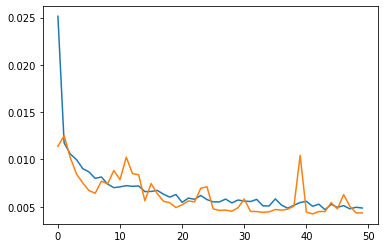

In [48]:
epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])

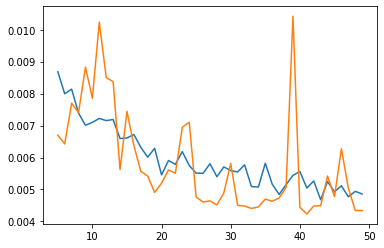

In [49]:
plt.plot(epochs[5:], history.history['loss'][5:])
plt.plot(epochs[5:], history.history['val_loss'][5:])

In [50]:
# helper fucntions included from tensorflow.org
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    
    time_steps = create_time_steps(plot_data[0].shape[0]) 
    
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [51]:
def forecast(model, inputs, target, indx):
    
    preds = model.predict(inputs)
    
    x = inputs[indx, :, 0].reshape((inputs.shape[1], 1))
    
    plot = show_plot([x, target[indx],
                    preds[indx]], 0, 'Simple LSTM model')
    plot.show()

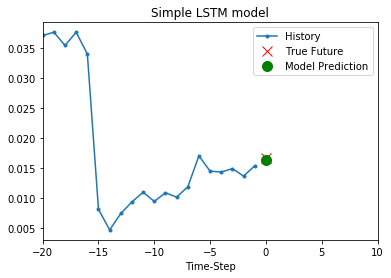

In [52]:
forecast(model, x_val, y_val, 11)